In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os
%matplotlib inline
import splitfolders

In [2]:
splitfolders.ratio ('D:/Other Projects/Crack detection/crack_data2', output = 'out', seed = 1317, ratio = (0.8, 0.1, 0.1))

In [3]:
BATCH = 26
IMG_WIDTH = 96
IMG_HEIGHT = 96

In [4]:
train_loader = tf.keras.preprocessing.image_dataset_from_directory ('D:/Other Projects/Crack detection/out/train', seed = 123, image_size = (IMG_HEIGHT, IMG_WIDTH), batch_size = BATCH)
test_loader = tf.keras.preprocessing.image_dataset_from_directory ('D:/Other Projects/Crack detection/out/test', seed = 123, image_size = (IMG_HEIGHT, IMG_WIDTH), batch_size = BATCH)
validation_loader = tf.keras.preprocessing.image_dataset_from_directory ('D:/Other Projects/Crack detection/out/val', seed = 123, image_size = (IMG_HEIGHT, IMG_WIDTH), batch_size = BATCH)

Found 32000 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.
Found 4000 files belonging to 2 classes.


In [5]:
class_names = train_loader.class_names
print (class_names)

['Negative', 'Positive']


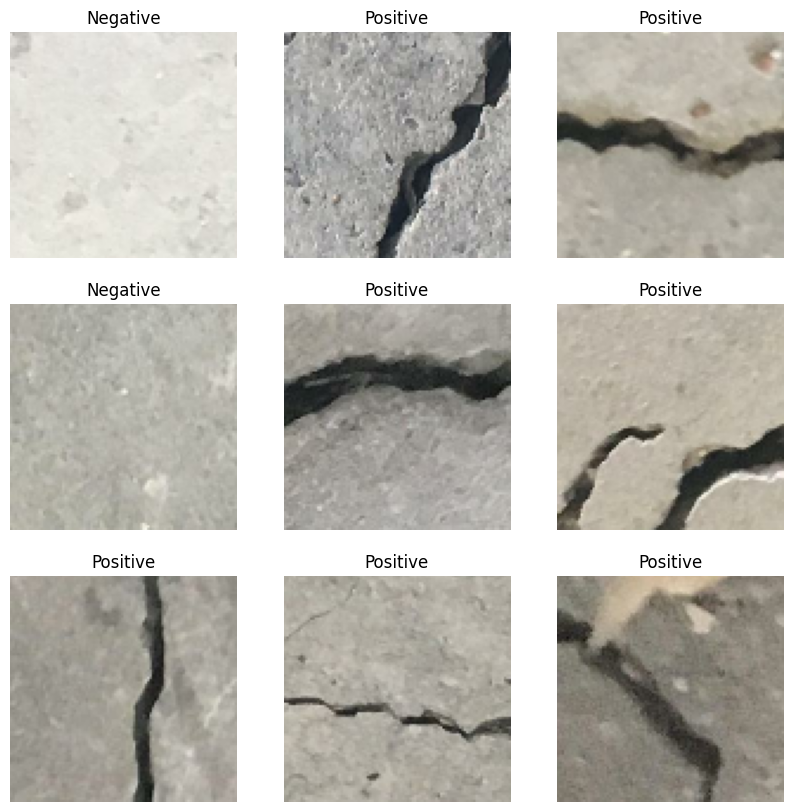

In [6]:
plt.figure (figsize = (10, 10))
for images, labels in train_loader.take(1):
    for i in range (9):
        ax = plt.subplot (3, 3, i+1)
        plt.imshow (images[i].numpy().astype ("uint8"))
        plt.title (class_names[labels[i]])
        plt.axis("off")

In [7]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_loader.cache().shuffle(1000).prefetch (buffer_size = AUTOTUNE)
test_dataset = test_loader.cache().prefetch (buffer_size = AUTOTUNE)
val_dataset = validation_loader.cache().prefetch (buffer_size = AUTOTUNE)

In [8]:
from keras.applications import VGG16
from keras import layers
from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import ImageDataGenerator

In [9]:
vgg_conv = tf.keras.applications.vgg16.VGG16(
    include_top=False,
    weights='imagenet',
    input_shape=(96, 96, 3),
    classes = 1
)

In [10]:
for layer in vgg_conv.layers[:-8]:
    layer.trainable = False

In [11]:
x = vgg_conv.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = Dense(2, activation="softmax")(x)
model = tf.keras.Model(vgg_conv.input, x)
model.compile(loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False), optimizer = optimizers.SGD(lr=0.0001, momentum=0.9), metrics=["accuracy"])

C:\Users\Priyanshu\AppData\Roaming\Python\Python310\site-packages\keras\optimizers\optimizer_v2\gradient_descent.py:111: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 96, 96, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 96, 96, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 48, 48, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 48, 48, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 48, 48, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 24, 24, 128)       0     

In [13]:
epochs = 10
history = model.fit(
    train_dataset,
    validation_data = val_dataset,
    epochs = epochs
)

Epoch 1/10
1231/1231 [==============================] - 2923s 2s/step - loss: 0.0176 - accuracy: 0.9959 - val_loss: 0.0034 - val_accuracy: 0.9992
Epoch 2/10
1231/1231 [==============================] - 10549s 9s/step - loss: 0.0030 - accuracy: 0.9992 - val_loss: 0.0032 - val_accuracy: 0.9987
Epoch 3/10
1231/1231 [==============================] - 25125s 20s/step - loss: 0.0016 - accuracy: 0.9997 - val_loss: 0.0023 - val_accuracy: 0.9995
Epoch 4/10
1231/1231 [==============================] - 3003s 2s/step - loss: 0.0011 - accuracy: 0.9998 - val_loss: 0.0019 - val_accuracy: 0.9995
Epoch 5/10
1231/1231 [==============================] - 2845s 2s/step - loss: 7.9376e-04 - accuracy: 0.9998 - val_loss: 0.0018 - val_accuracy: 0.9995
Epoch 6/10
1231/1231 [==============================] - 2730s 2s/step - loss: 6.4399e-04 - accuracy: 0.9999 - val_loss: 0.0026 - val_accuracy: 0.9992
Epoch 7/10
1231/1231 [==============================] - 2797s 2s/step - loss: 5.1780e-04 - accuracy: 0.9999 - val

In [14]:
loss, accuracy = model.evaluate(test_dataset)

154/154 [==============================] - 107s 690ms/step - loss: 0.0111 - accuracy: 0.9980


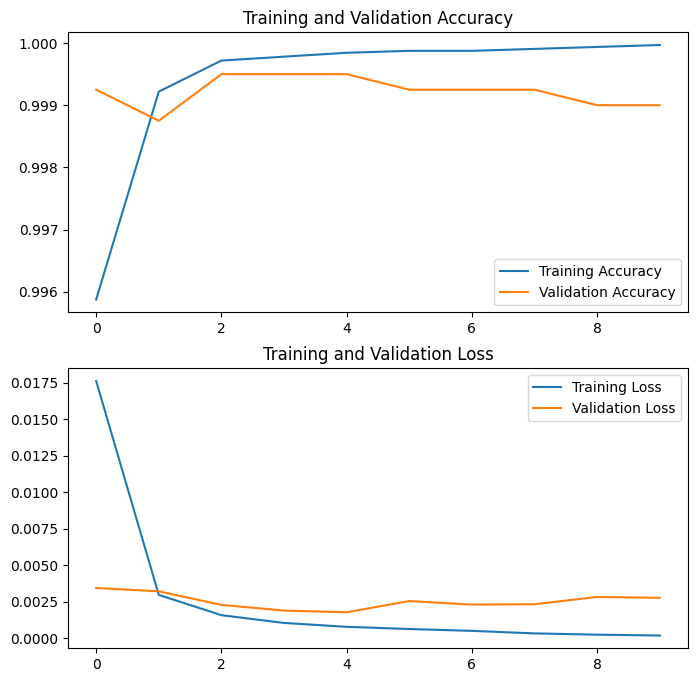

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [35]:
import scipy as sp

In [36]:
def plot_activation(img):
    pred = model.predict(img[np.newaxis,:,:,:])
    pred_class = np.argmax(pred)
    weights = model.layers[-1].get_weights()[0]
    class_weights = weights[:, pred_class]
    intermediate = tf.keras.Model(model.input,
                         model.get_layer("block5_conv3").output)
    conv_output = intermediate.predict(img[np.newaxis,:,:,:])
    conv_output = np.squeeze(conv_output)
    h = int(img.shape[0]/conv_output.shape[0])
    w = int(img.shape[1]/conv_output.shape[1])
    act_maps = sp.ndimage.zoom(conv_output, (h, w, 1), order=1)
    out = np.dot(act_maps.reshape((img.shape[0]*img.shape[1],512)), 
                 class_weights).reshape(img.shape[0],img.shape[1])
    plt.imshow(img.astype('float32').reshape(img.shape[0],
               img.shape[1],3))
    plt.imshow(out, cmap='jet', alpha=0.35)
    plt.title('Crack' if pred_class == 1 else 'No Crack')

1/1 [==============================] - 0s 133ms/step


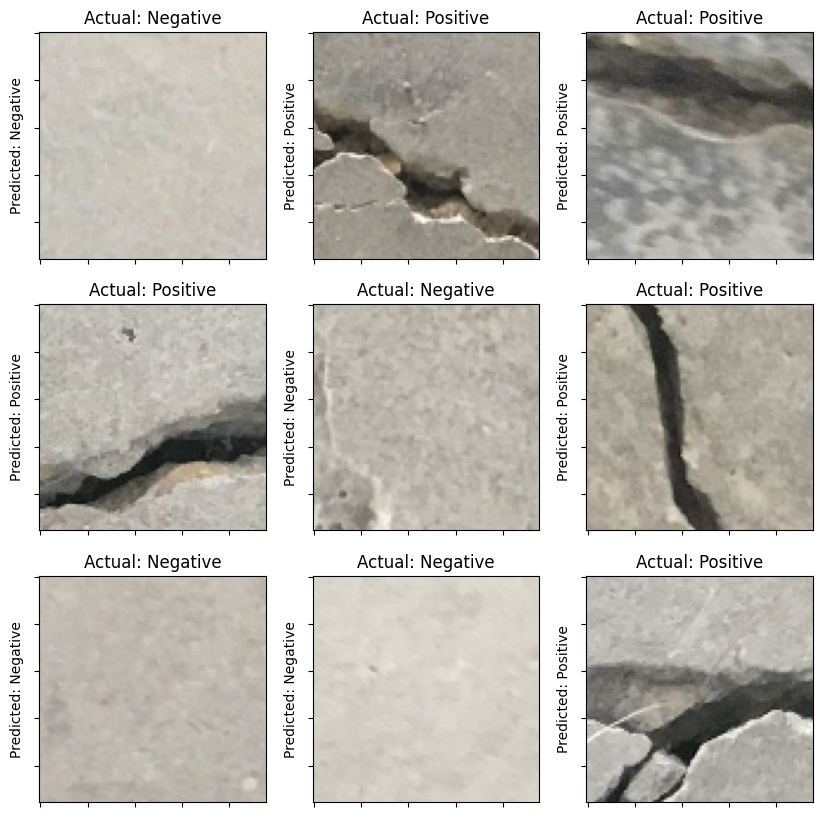

In [37]:
plt.figure(figsize=(10, 10))
for images, labels in test_loader.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predictions = model.predict(tf.expand_dims(images[i], 0))
        score = tf.nn.softmax(predictions[0])
        plt.ylabel("Predicted: "+class_names[np.argmax(score)])
        plt.title("Actual: "+class_names[labels[i]])
        plt.gca().axes.yaxis.set_ticklabels([])        
        plt.gca().axes.xaxis.set_ticklabels([])

In [38]:
import cv2
import glob
import matplotlib.image as mpimg
import pandas

In [39]:
image = glob.glob("D:/Other Projects/Crack detection/crack_data2/Positive/00001.jpg")
n = cv2.imread ("D:/Other Projects/Crack detection/crack_data2/Positive/00001.jpg")

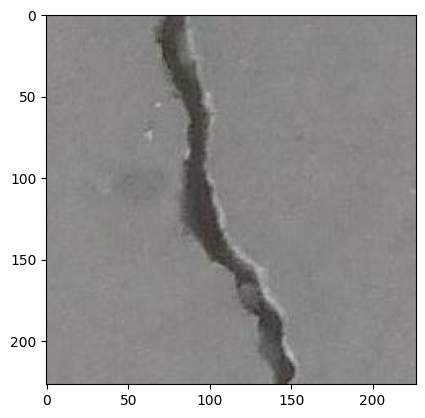

In [40]:
plt.imshow (n)
n = cv2.resize (n, (96, 96))

1/1 [==============================] - 0s 284ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


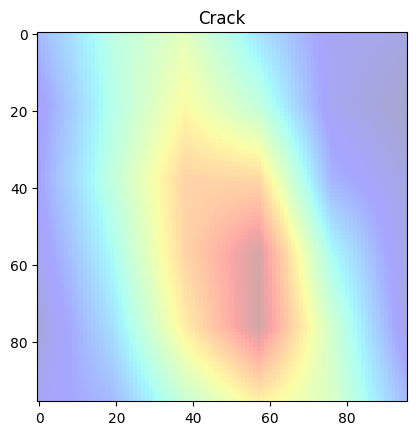

In [48]:
plot_activation (n)

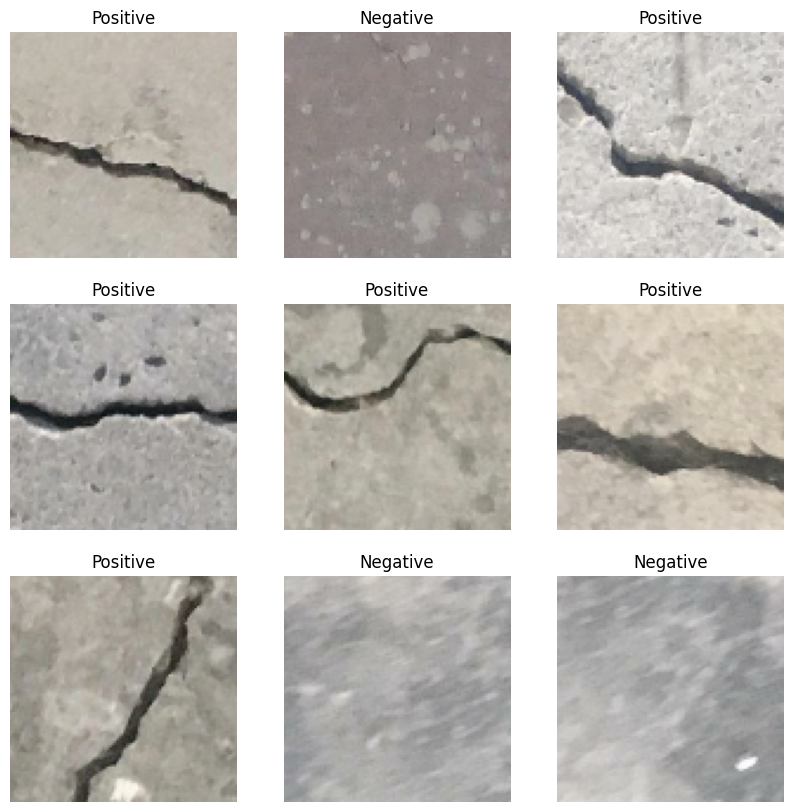

In [49]:
plt.figure(figsize = (10, 10))
for images, labels in train_loader.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

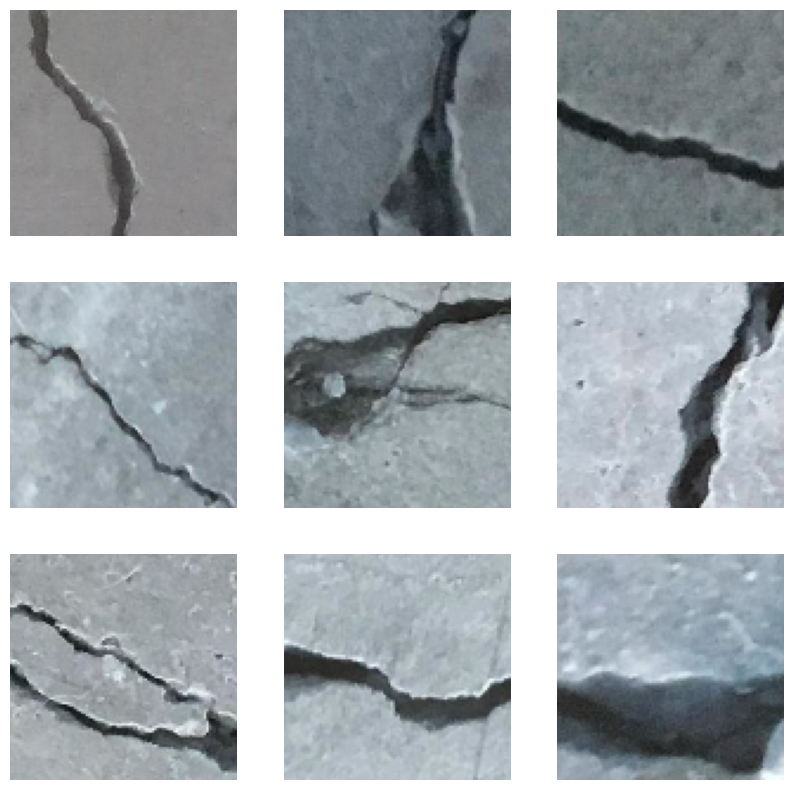

In [62]:
img = []
for imag in glob.glob ("D:/Other Projects/Crack detection/forheatmap/*.jpg"):
    n = cv2.imread (imag)
    n = cv2.resize (n, (96, 96))
    img.append (n)



plt.figure (figsize = (10, 10))
for images in img:
    for i in range (9):
        ax = plt.subplot (3, 3, i+1)
        plt.imshow (img[i])
        plt.axis ("off")

1/1 [==============================] - 0s 380ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 349ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 348ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 366ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 246ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 200ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 240ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 209ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 179ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 205ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 240ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 199ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 220ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 263ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 455ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 230ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 476ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 433ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 219ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 196ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 189ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 320ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 391ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 286ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 371ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 366ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 419ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 236ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 192ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 229ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 241ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 201ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 179ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 194ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 190ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 229ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 276ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 200ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 211ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 188ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 380ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 1s 539ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 380ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 248ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 187ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 187ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 192ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 201ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 242ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 227ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 209ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 199ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 194ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 179ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 199ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 210ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 223ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 200ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 233ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 188ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 200ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 241ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 309ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 335ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 172ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 165ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 283ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 221ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 171ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 179ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 323ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 198ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 478ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 360ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 460ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 306ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 252ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 298ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 1s 530ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 381ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1/1 [==============================] - 0s 181ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


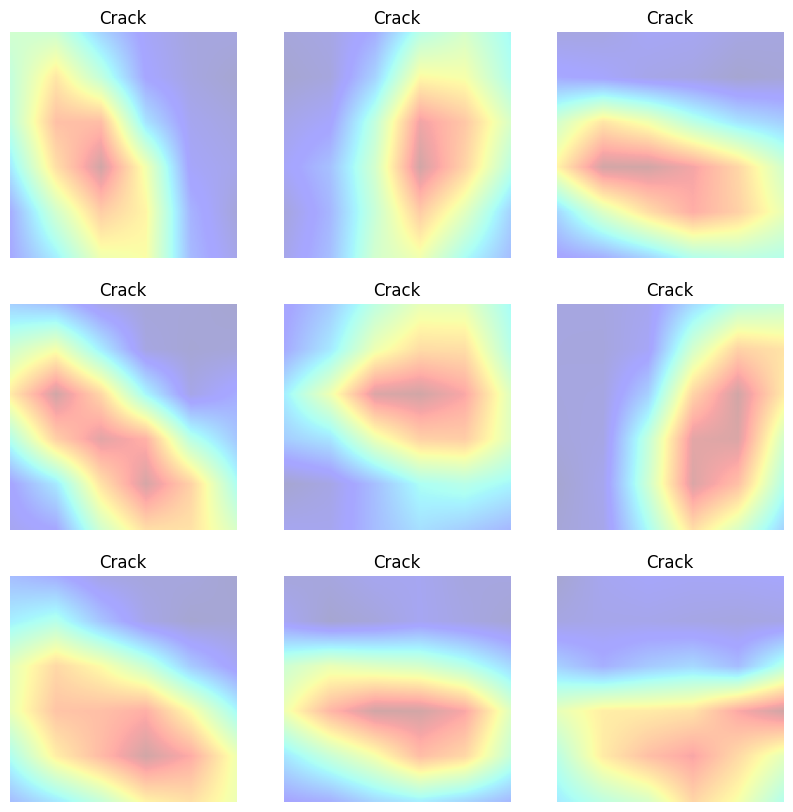

In [63]:
plt.figure (figsize = (10, 10))
for images in img:
    for i in range (9):
        ax = plt.subplot (3, 3, i+1)
        plot_activation (img[i])
        plt.axis ("off")